# dominating set

Set up calculations and store in EspressoDB

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import graph_summary, experiment_summary, data_summary, insert_result, QUBO_to_Ising

from networkx import Graph
from networkx.algorithms.approximation import min_weighted_dominating_set

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

In [ ]:
# Define Adjacency matrix
# Hamming(d,q)
# Biparti
# NN(v): 1D nearest neighbor with v vertices. max is 16 before minor embedding starts breaking
#graph, tag = gt.generate_hamming_graph(1, 2)
#graph, tag = gt.generate_bipartite_graph(3, 3)
for nvertices in range(4,5):
    graph, tag = gt.generate_erdos_renyi_graph(nvertices, 0.1)
    penalty = 2

    directed = False
    qubo = get_mds_qubo(graph, directed=directed, penalty = penalty, triangularize=True, dtype="d")
    q_min = np.array(list(qubo.values())).min()

    gt.get_plot(graph, directed=directed)
    plt.show()
    graph_params = graph_summary(tag, graph)
    print(graph_params)

    # Experiment
    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))
    #print("Initial")
    #print(f"max(J) = {maxJ}")
    #print(f"max(h) = {maxh}")
    #print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
    #print("Must scale QUBO to these ranges\n")
    fact = 1 #max([maxJ, maxh/2]) * 1.2
    qubo = qubo / fact

    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))
    #print("Rescaled")
    #print(f"max(J) = {maxJ}")
    #print(f"max(h) = {maxh}")
    #print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
    #print("Must scale QUBO to these ranges\n")

    # Set chain strength
    chain_strength = maxJ*2
    print(f"Chain strength: {chain_strength}")

In [ ]:
    # DWave settings
    dwave_config = {
        "annealing_time": 500,  # integer microseconds [1, 2000]
        "answer_mode": "raw", # histogram or raw
        "auto_scale": True,
        "num_reads": 1000,  # raw will dump out all results
        "num_spin_reversal_transforms": 0,
        "readout_thermalization": 0, # default 0
        "programming_thermalization": 1000, # default 1000
        "chain_strength": chain_strength
    }
    solver = "DW_2000Q_5"

    experiment_params = experiment_summary(machine=solver, settings=dwave_config, penalty=penalty, factor=fact, chain_strength=chain_strength, qubo=qubo)


    # Solve on DWave and push to database
    sampler = DWaveSampler(solver=solver)
    embed = EmbeddingComposite(sampler)
    qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}
    for idx in range(10):
        print(idx)
        result = embed.sample_qubo(qubo_dict, **dwave_config)
        raw = result.to_pandas_dataframe()
        data_params = data_summary(raw, graph_params, experiment_params)
        result = insert_result(graph_params, experiment_params, data_params)
    print(raw.sort_values("energy", ascending=True).head())

In [ ]:
#classical_search(qubo)

In [ ]:
from qlpdb.data.models import Data as data_Data

In [ ]:
data_Data.objects.filter(experiment__graph__tag="NN(2)").to_dataframe()

In [ ]:
for nvertices in range(3,5):
    graph, tag = gt.generate_bipartite_graph(1, nvertices)
    penalty = 2

    directed = False
    qubo = get_mds_qubo(graph, directed=directed, penalty = penalty, triangularize=True, dtype="d")
    q_min = np.array(list(qubo.values())).min()

    gt.get_plot(graph, directed=directed)
    plt.show()
    graph_params = graph_summary(tag, graph)
    print(graph_params)

In [36]:
graph, tag = gt.generate_erdos_renyi_graph(10, 0.2)
graph

{(0, 1), (0, 5), (0, 6), (0, 9), (2, 3), (3, 8), (5, 8), (6, 8)}

In [34]:
from networkx.algorithms.approximation.dominating_set import min_weighted_dominating_set
import networkx as nx
G = nx.Graph()
G.add_edges_from(graph)
min_weighted_dominating_set(G)

set()

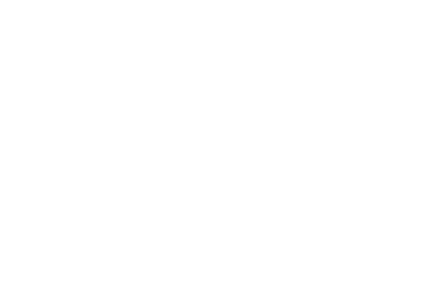

In [35]:
from networkx.drawing.nx_pylab import draw
draw(G)